# Python fundamentals

<div class="objectives">
  
### Objectives

- Learn the basic Pandas data structures and methods
- Explore a typical data manipulation and plotting process

</div>

### References
[Pandas API Reference](https://pandas.pydata.org/docs/reference/index.html)




In [1]:
#Import libraries and datasets
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import dask

ts_data = dask.datasets.timeseries()
df = sns.load_dataset('diamonds')
df.head() #inspect dataframe


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [2]:
#dataframe attributes can be accessed

df.index #name of index, in this case a range
df.columns #variables carat to z
df.values # values as a numpy.ndarray
df.dtypes # datatypes of variables
df.shape # rows to column structure
df.ndim # number dimensions

#functions are attached to pd.Series can be engaged
df.cut    # referenced column on its own
df.cut.value_counts()   
df.cut.unique()
df.carat.mean()

0.7979397478680014

### DataFrame Functions
Functions are available that are attached to the DataFrame class
Common methods are: 

- **filter**: Subset the dataframe rows or columns according to the specified index labels. 
- **assign**: assign / mutate new columns in dataframe
- **query**: query the columns of a DataFrame with a boolean expression
- **sort_values** : arrange rows of DataFrame
- **apply** : Apply a function along an axis of the DataFrame

In [3]:
#More complex subsetting of dataframe by observations or variables

#filter variables
df.filter(['cut']) #returns pandas.DataFrame
df['cut'] # as opposed to this which returns pandas.Series or df.cut
df.filter(["carat","cut"]) #filter more than one variables 
df.filter(regex=  "^c") #with regex - a whole other topic..

#query observations
#The quotes in query need to be single-outside, double-inside 
df.query('color == "E"') #filter observations by criteria
df.query('cut == "Ideal" or cut == "Premium"') #filter observations with logical expression
df.query('cut == "Ideal" | cut == "Premium"')  #same thing
df.query("cut.str.match('^G')") #query doesnt have regex parameter but can be incorporated via str attribute
df.query("clarity.str.contains('^\w+1')")
df.query('price > 500') #querying numeric

#pther ways to filter variables or observations by string exist
subset = [col for col in df.columns.str.contains('c')] #list comprehension returning list of booleans
df.filter(df.columns[subset]) #which are tweeked to filter command
df[df.cut.str.startswith('Good')] #subsetting observations 

#most datframe functions return a dataframe so one can combine different DataFrame operations
df.query('price < 500').head() 

#chaining manipluations into larger readable structure
(df
 .filter(['carat', 'color'])
 .query('color == "E"')
 .head(3))

# or using functions applied after a chain
(df
    .query('price < 4000')
    .price.std())

#while we've only so far looked at functions attached to pd.Dataframe,
#one can use external functioned provided what it expects is catered for.

np.linalg.norm(df.filter(['x','y','z']).values) #norm expects an array



2094.3009834071127

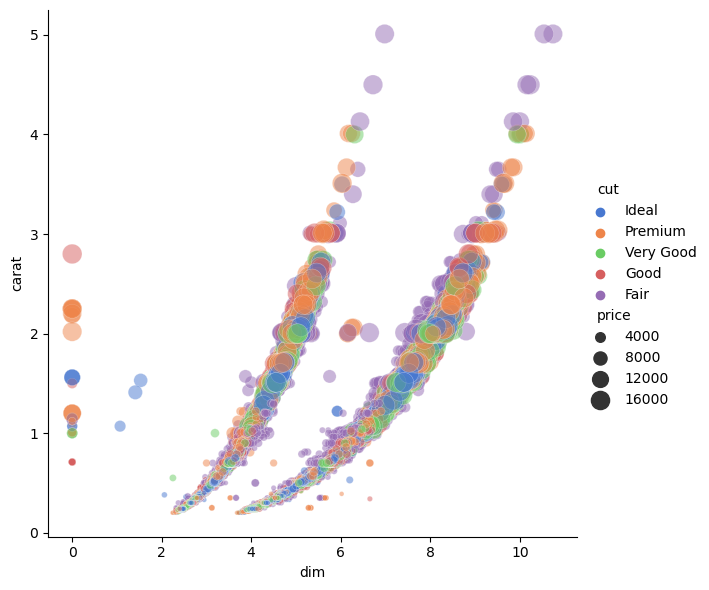

In [5]:

# arrange data by values
df.sort_values(by = ['carat','price'],ascending = False)

# groupby: splits dataframe into multiple compartments and returns a group-by object
# which aggregations can be applied on each group
df.groupby('cut').price.agg('std')
df.groupby('cut').mean(numeric_only=True)

# Using assign to create / mutate a variable

df.assign(size = 1) #fills same value
df = df.assign(size = np.sqrt(df.x ** 2 + df.y ** 2 + df.z ** 2)) #element wise vector addition

#apply : apply a function to a DataFrame over columns (axis = 1) or rows (axis = 0) 
df.assign(norm = df.filter(['x','y','z']).apply(np.linalg.norm,axis = 1)) #element / rowwise norm equivalent

df.assign(demeaned = lambda df : df.price - df.price.mean()) 

#if aggregation is based on grouping
df_cut = df.groupby('cut')
df.assign(demeaned = df.price - df_cut.price.transform('mean')) #transform

# map : Map values of Series according to an input mapping or function.
# very similar to apply but acts on pd.Series rather than pd.DataFrame

df.price.map(lambda r : r + 1) #returns a pd.Series

#applymap: Apply a function to a Dataframe elementwise
df.filter(['x','y','z']).applymap(lambda x : x **2) 

#Reshaping data with melt
#melt converts data to long format. pivot is the column equivalent to exand data wider
''' some melt arguments are :
id_vars ; Column(s) to use as identifier variables
value_vars ; Column(s) to unpivot. If not specified, uses all columns that are not set as id_vars.
var_name ; Name to use for the ‘variable’ column
value_name ; Name to use for the ‘value’ column
'''

df_longer = (df.filter(['cut','carat','clarity','x','y','z','price'])
    .melt(id_vars=['cut','price','clarity','carat'], 
    value_vars = ['x','y','z'],
    value_name = "dim"
     )
)

#longer format usually good for plotting.

sns.relplot(x="dim", y="carat", hue="cut", size="price",
            sizes=(10, 200), alpha=.5, palette="muted",
            height=6, data=df_longer.query('dim < 12'))


<div class="challenge">

### Challenge 

Make a plot of the carat vs price, group the colors by the cut and the symbol size by the color of the diamond. Limit the dataset to just show the "I1" clarity.

<details>
<summary>Solution</summary>

This can be done in a few ways, but Seaborn interfaces with pandas-like dataframes seamlessly to make these simple data-manging tasks easy. 
    
```python   
sns.relplot(x="carat", y="price", hue="cut",size='color',
        sizes=(10, 200), alpha=.5, palette="muted",
        height=6, data=data.query('clarity == "I1"'))
```
</details>
</div>

### Caching results and Building manipulations in memory

In [6]:

# Techniques for writing efficient python:
# understanding the different between mutable and immutable 
# use np functions rather than function written in pure python
# consider generators 
# caching results

#https://caam37830.github.io/book/index.html
#https://python-course.eu/
#https://realpython.com/fibonacci-sequence-python/

def FibonacciGenerator(n):
    """ note: n is limit of fibonacci value rather than count
    """
    a = 0
    b = 1
    while a < n:
        yield a
        a, b = b, a + b
        
# Recursive slower case
def fibonacci_of(n):
    if n in {0, 1}:  # Base case
        return n
    return fibonacci_of(n - 1) + fibonacci_of(n - 2)  #return same function 

def is_even(sequence):
    """ reduces a sequence to even numbers
    """
    for n in sequence:
        if n % 2 == 0:
            yield n

In [7]:
#Can consume generators by converting to list
list(is_even([1,2,3,4]))
list(FibonacciGenerator(500))

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]

In [8]:
#Build up sequences of manuplations in memory with generators 
# and selectively trigger consumption for efficiency
list(is_even(FibonacciGenerator(500)))

[0, 2, 8, 34, 144]

In [9]:
%%timeit #758 nanos ± 0.393 ns per loop
results1 = list(FibonacciGenerator(500)) #generator brought into memory via list

1.98 µs ± 129 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
%%timeit #192 microsec ± 1.92 ns per loop
results2 = [fibonacci_of(n) for n in range(15)]

433 µs ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
#Caching is another method to improve efficiency, new syntax as of Python 3.9
from functools import cache

@cache
def factorial(n):
    return n * factorial(n-1) if n else 1

In [12]:
factorial(10) # no previously cached result, makes 11 recursive calls
factorial(5) # just looks up cached value result
factorial(12) # makes two new recursive calls, the other 10 are cached

479001600

<div class="keypoints">

### Key points

- pd.DataFrame and pd.Series are the most common data structures for tabular data.
- Functions are "attatched" to the objects. For example pd.Series.sum(), pd.Series.str.contains(), pd.Series.quantile() etc
- The Pandas API is an invaluable reference to remember the notations.

</div>
